# MSCI 446 Project
### Fahmid Ahmed (21000633), Mithunan Jegatheesan, Krish Aaryan Sethi (21001979), Nabeel Siddiqui (21008646), Christopher Yu (21002410)

##Introduction
Our project applies machine learning to classify and predict NBA player injuries based on historical data. By combining injury reports, player statistics, and game context, we trained models to determine the likelihood of a player being injured.

This system will help teams:
- Make informed decisions around player workload and rest
- Refine training and recovery plans
- Proactively prevent injuries to improve player longevity and team success
---

##Data Description
This dataset was created to support our machine learning project on **NBA player injury prediction**. It merges multiple sources of player-level performance and injury data to build a feature-rich training set that can be used to model injury risk across seasons.

### Objective
The goal is to predict **whether an NBA player is likely to get injured during a season** based on their physical attributes, workload, performance trends, and historical injury data.

---

###  Data Sources

We combined two major sources to build this dataset:

1. **Player Performance Data**  
   Source: [NBA.com/stats](https://www.nba.com/stats/)  
   Collected using the NBA Stats API (via web scraping and requests).  
   Includes player-level statistics such as:
   - Advanced metrics (USG%, PACE, NET_RATING, etc.)
   - Tracking stats (touches, pull-ups, drives, distance, speed)
   - Biometric data (age, height, weight)
   - Game participation (minutes, games played)

2. **Injury History Data**  
   Source: [Pro Sports Transactions](https://www.prosportstransactions.com/basketball/)  
   Scraped and cleaned using a custom Python web scraper.  
   Includes player injury logs such as:
   - Injury start and return dates
   - Body part affected (e.g., knee, ankle, back)
   - Days missed
   - Team and season context

---

### Dataset Composition

- **Rows**: ~10,750  
- **Unit**: Each row represents a **unique player-season** (i.e. LeBron James 2022-23 is one row)
- **Timeframe**: Seasons from **2013–14 to 2023–24**
- **Columns**: 50+ including:
  - Player bio: `AGE`, `HEIGHT`, `WEIGHT`
  - Workload: `MIN`, `POSS`, `PACE`, `DIST_MILES`, `AVG_SPEED`
  - Shot types: `PULL_UP_FGA`, `DRIVES`, `FGA_PG`
  - Touches & usage: `TOUCHES`, `ELBOW_TOUCHES`, `AVG_SEC_PER_TOUCH`
  - Injury data: `Injured Date`, `Returned Date`, `Days Missed`, `Injury Type`
  - Outcome variable: **binary signal for injury occurrence in a given season**

---

###  Dataset Appropriateness

Injury prediction is highly contextual — it depends on workload, player health history, fatigue, and performance variability. This dataset directly addresses that by:

- Including **high-resolution player tracking metrics** to measure fatigue and physical strain (e.g., speed, touches, drives)
- Capturing **historical injury timelines** and durations, allowing us to define target labels for classification (e.g. "was injured this season")
- Merging performance and injury timelines into one view, enabling supervised learning models to learn from both past patterns and present workload

By merging both performance and injury sources into a single feature space, this dataset allows us to build machine learning models that can **quantify and predict injury risk** for NBA players.

---

## Considerations in Building the Model

### Class Imbalance
- The final dataset had a moderately imbalanced split of 75% injury (class 1) and 25% non-injury (class 0).
- In such cases, accuracy is a misleading metric, as a model can achieve high accuracy by simply predicting the majority class.
- This was evident when the initial Logistic Regression model achieved approximately 75.6% accuracy, despite failing to correctly predict non-injury cases, indicating that it was not truly learning the underlying patterns.

### Strategy for Handling Imbalance
- Instead of relying on accuracy, we focused on metrics better suited for imbalanced classification:
  - F1-score and recall, especially for the injury class.
  - This is because false negatives (missed injuries) are particularly dangerous.
- To address the imbalance, we applied algorithmic penalties using:
  - `class_weight='balanced'` in classifiers such as Logistic Regression, Decision Tree, Random Forest, etc.
  - This instructs the model to pay greater attention to the minority class (non-injury) during training.

### Decision to Not Use Sampling Techniques

- **Undersampling the Majority (Injury):**
  - Not used because it would discard a large portion of injury data, which is valuable in understanding the full range of injury cases.

- **Oversampling the Minority (Non-Injury):**
  - Not used because:
    - It may make the model overly cautious about predicting injury cases.
    - Our goal is to avoid missing injury cases, and oversampling could reduce the model’s sensitivity to them.
    - The imbalance, while present, is not extreme (75-25), so oversampling was not necessary.

### Final Model Selection Approach

- Models were evaluated based on:
  - Recall of the injury class (class 1)
  - F1-score to balance precision and recall
  - ROC-AUC to assess the model’s ability to distinguish between injury and non-injury cases
- The final selected model achieves high recall and strong F1-score, making it well-suited for the injury classification task where minimizing false negatives is critical.



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')

import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay,classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Load the Dataset

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/446 Project/final_player_stats_with_injuries2.csv')
df.head()

,PLAYER_ID,PLAYER_NAME,SEASON,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,REB,PTS,...,ELBOW_TOUCHES,POST_TOUCHES,PAINT_TOUCHES,TEAM_ABBREVIATION,TEAM,Injured Date,Returned Date,Days Missed,Injury Type,Notes
0,201985,AJ Price,2013-14,27.0,74.0,195.0,28,3.5,0.4,1.6,...,0.0,0.0,0.0,MIN,Timberwolves,NaN,NaN,NaN,NaN,NaN
1,201166,Aaron Brooks,2013-14,29.0,72.0,161.0,72,21.6,1.9,9.0,...,0.3,0.0,0.7,DEN,Nuggets,NaN,NaN,NaN,NaN,NaN
2,201189,Aaron Gray,2013-14,29.0,84.0,270.0,37,9.6,3.0,1.8,...,1.6,0.4,2.0,SAC,Kings,NaN,NaN,NaN,NaN,NaN
3,203519,Adonis Thomas,2013-14,21.0,79.0,240.0,6,6.3,0.5,2.3,...,0.0,0.2,0.0,PHI,76ers,NaN,NaN,NaN,NaN,NaN
4,1733,Al Harrington,2013-14,34.0,81.0,245.0,34,15.0,2.4,6.6,...,0.7,0.6,1.2,WAS,Wizards,2013-12-09,2014-02-22,75.0,knee,placed on IL recovering from arthroscopic surg...


In [ ]:
df['Out Indefinitely'] = df['Notes'].str.contains('out indefinitely') | df['Notes'].str.contains('out for season')
df.head()

,PLAYER_ID,PLAYER_NAME,SEASON,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,REB,PTS,...,POST_TOUCHES,PAINT_TOUCHES,TEAM_ABBREVIATION,TEAM,Injured Date,Returned Date,Days Missed,Injury Type,Notes,Out Indefinitely
0,201985,AJ Price,2013-14,27.0,74.0,195.0,28,3.5,0.4,1.6,...,0.0,0.0,MIN,Timberwolves,NaN,NaN,NaN,NaN,NaN,False
1,201166,Aaron Brooks,2013-14,29.0,72.0,161.0,72,21.6,1.9,9.0,...,0.0,0.7,DEN,Nuggets,NaN,NaN,NaN,NaN,NaN,False
2,201189,Aaron Gray,2013-14,29.0,84.0,270.0,37,9.6,3.0,1.8,...,0.4,2.0,SAC,Kings,NaN,NaN,NaN,NaN,NaN,False
3,203519,Adonis Thomas,2013-14,21.0,79.0,240.0,6,6.3,0.5,2.3,...,0.2,0.0,PHI,76ers,NaN,NaN,NaN,NaN,NaN,False
4,1733,Al Harrington,2013-14,34.0,81.0,245.0,34,15.0,2.4,6.6,...,0.6,1.2,WAS,Wizards,2013-12-09,2014-02-22,75.0,knee,placed on IL recovering from arthroscopic surg...,False


In [ ]:
df['Injury Type'].value_counts()

,count
Injury Type,
unspecified,3165
knee,1035
ankle,978
back,392
hamstring,279
hip,268
foot,263
shoulder,203
calf,191


##Function to categorize injuries
This function is adapted from Cheung, Cheou, Kassem, Rivas II, and Jin (n.d.), a GitHub repository analyzing a similar dataset.

In [ ]:
def categorize_injury(injury):
    if injury in ['hand', 'wrist', 'thumb', 'finger']:
        return 'Hand'
    elif injury in ['facial', 'jaw', 'cheekbone', 'orbital', 'nose', 'eye', 'oral', 'cornea', 'forehead','throat','face']:
        return 'Facial'
    elif injury in ['back', 'spinal cord', 'tailbone']:
        return 'Back'
    elif injury in ['leg', 'thigh', 'tibia', 'shin', 'quadricep', 'hamstring', 'knee','patella', 'kneecap', 'calf','Achilles','adductor','fibula', 'ankle']:
        return 'Leg'
    elif injury in ['plantar','foot', 'heel', 'toe']:
        return 'Foot'
    elif injury in ['forearm','elbow', 'arm','tricep','bicep','biceps','triceps','flexor']:
        return 'Arm'
    elif injury in ['shoulder', 'chest', 'collarbone', 'rib','abdominal', 'abdomen', 'heart', 'lung', 'pectoral','disc']:
        return 'Upper Body'
    elif injury in ['hip', 'groin', 'pelvis', 'gluteus','quadricap']:
        return 'Lower Body'
    elif injury in ['head','concussion', 'neck','cervical']:
        return 'Head'
    else:
        return 'Others'

In [ ]:
df['body_part'] = df['Injury Type'].apply(categorize_injury)
df

,PLAYER_ID,PLAYER_NAME,SEASON,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,REB,PTS,...,PAINT_TOUCHES,TEAM_ABBREVIATION,TEAM,Injured Date,Returned Date,Days Missed,Injury Type,Notes,Out Indefinitely,body_part
0,201985,AJ Price,2013-14,27.0,74.0,195.0,28,3.5,0.4,1.6,...,0.0,MIN,Timberwolves,NaN,NaN,NaN,NaN,NaN,False,Others
1,201166,Aaron Brooks,2013-14,29.0,72.0,161.0,72,21.6,1.9,9.0,...,0.7,DEN,Nuggets,NaN,NaN,NaN,NaN,NaN,False,Others
2,201189,Aaron Gray,2013-14,29.0,84.0,270.0,37,9.6,3.0,1.8,...,2.0,SAC,Kings,NaN,NaN,NaN,NaN,NaN,False,Others
3,203519,Adonis Thomas,2013-14,21.0,79.0,240.0,6,6.3,0.5,2.3,...,0.0,PHI,76ers,NaN,NaN,NaN,NaN,NaN,False,Others
4,1733,Al Harrington,2013-14,34.0,81.0,245.0,34,15.0,2.4,6.6,...,1.2,WAS,Wizards,2013-12-09,2014-02-22,75.0,knee,placed on IL recovering from arthroscopic surg...,False,Leg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10742,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,3.8,NOP,Pelicans,2024-01-07,2024-01-10,3.0,leg,placed on IL with bruised leg,False,Leg
10743,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,3.8,NOP,Pelicans,2024-01-26,2024-01-27,1.0,foot,bruised left foot (DTD),False,Foot
10744,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,3.8,NOP,Pelicans,2024-01-31,2024-02-02,2.0,foot,placed on IL with bruised left foot,False,Foot
10745,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,3.8,NOP,Pelicans,2024-02-10,2024-02-12,2.0,foot,placed on IL with bruised left foot,False,Foot


In [ ]:
def season_to_num(season_str):
    try:
        start_year = int(season_str.split("-")[0])
        return start_year % 100 + 0.5  # e.g. 2013 → 13.5
    except:
        return None

df['SEASON_NUM'] = df['SEASON'].apply(season_to_num)


df

,PLAYER_ID,PLAYER_NAME,SEASON,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,REB,PTS,...,TEAM_ABBREVIATION,TEAM,Injured Date,Returned Date,Days Missed,Injury Type,Notes,Out Indefinitely,body_part,SEASON_NUM
0,201985,AJ Price,2013-14,27.0,74.0,195.0,28,3.5,0.4,1.6,...,MIN,Timberwolves,NaN,NaN,NaN,NaN,NaN,False,Others,13.5
1,201166,Aaron Brooks,2013-14,29.0,72.0,161.0,72,21.6,1.9,9.0,...,DEN,Nuggets,NaN,NaN,NaN,NaN,NaN,False,Others,13.5
2,201189,Aaron Gray,2013-14,29.0,84.0,270.0,37,9.6,3.0,1.8,...,SAC,Kings,NaN,NaN,NaN,NaN,NaN,False,Others,13.5
3,203519,Adonis Thomas,2013-14,21.0,79.0,240.0,6,6.3,0.5,2.3,...,PHI,76ers,NaN,NaN,NaN,NaN,NaN,False,Others,13.5
4,1733,Al Harrington,2013-14,34.0,81.0,245.0,34,15.0,2.4,6.6,...,WAS,Wizards,2013-12-09,2014-02-22,75.0,knee,placed on IL recovering from arthroscopic surg...,False,Leg,13.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10742,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,NOP,Pelicans,2024-01-07,2024-01-10,3.0,leg,placed on IL with bruised leg,False,Leg,23.5
10743,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,NOP,Pelicans,2024-01-26,2024-01-27,1.0,foot,bruised left foot (DTD),False,Foot,23.5
10744,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,NOP,Pelicans,2024-01-31,2024-02-02,2.0,foot,placed on IL with bruised left foot,False,Foot,23.5
10745,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,NOP,Pelicans,2024-02-10,2024-02-12,2.0,foot,placed on IL with bruised left foot,False,Foot,23.5


In [ ]:
df.shape

(10747, 57)

In [ ]:
df['Out Indefinitely'].fillna(False, inplace=True)
df['Out Indefinitely'] = [1 if x == True else 0 for x in df['Out Indefinitely']]
df

<ipython-input-9-f64380bc731f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Out Indefinitely'].fillna(False, inplace=True)


,PLAYER_ID,PLAYER_NAME,SEASON,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,REB,PTS,...,TEAM_ABBREVIATION,TEAM,Injured Date,Returned Date,Days Missed,Injury Type,Notes,Out Indefinitely,body_part,SEASON_NUM
0,201985,AJ Price,2013-14,27.0,74.0,195.0,28,3.5,0.4,1.6,...,MIN,Timberwolves,NaN,NaN,NaN,NaN,NaN,0,Others,13.5
1,201166,Aaron Brooks,2013-14,29.0,72.0,161.0,72,21.6,1.9,9.0,...,DEN,Nuggets,NaN,NaN,NaN,NaN,NaN,0,Others,13.5
2,201189,Aaron Gray,2013-14,29.0,84.0,270.0,37,9.6,3.0,1.8,...,SAC,Kings,NaN,NaN,NaN,NaN,NaN,0,Others,13.5
3,203519,Adonis Thomas,2013-14,21.0,79.0,240.0,6,6.3,0.5,2.3,...,PHI,76ers,NaN,NaN,NaN,NaN,NaN,0,Others,13.5
4,1733,Al Harrington,2013-14,34.0,81.0,245.0,34,15.0,2.4,6.6,...,WAS,Wizards,2013-12-09,2014-02-22,75.0,knee,placed on IL recovering from arthroscopic surg...,0,Leg,13.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10742,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,NOP,Pelicans,2024-01-07,2024-01-10,3.0,leg,placed on IL with bruised leg,0,Leg,23.5
10743,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,NOP,Pelicans,2024-01-26,2024-01-27,1.0,foot,bruised left foot (DTD),0,Foot,23.5
10744,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,NOP,Pelicans,2024-01-31,2024-02-02,2.0,foot,placed on IL with bruised left foot,0,Foot,23.5
10745,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,NOP,Pelicans,2024-02-10,2024-02-12,2.0,foot,placed on IL with bruised left foot,0,Foot,23.5


In [ ]:
df['Injured'] = np.where(df['Injury Type'].notna(), 1, 0)
df

,PLAYER_ID,PLAYER_NAME,SEASON,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,REB,PTS,...,TEAM,Injured Date,Returned Date,Days Missed,Injury Type,Notes,Out Indefinitely,body_part,SEASON_NUM,Injured
0,201985,AJ Price,2013-14,27.0,74.0,195.0,28,3.5,0.4,1.6,...,Timberwolves,NaN,NaN,NaN,NaN,NaN,0,Others,13.5,0
1,201166,Aaron Brooks,2013-14,29.0,72.0,161.0,72,21.6,1.9,9.0,...,Nuggets,NaN,NaN,NaN,NaN,NaN,0,Others,13.5,0
2,201189,Aaron Gray,2013-14,29.0,84.0,270.0,37,9.6,3.0,1.8,...,Kings,NaN,NaN,NaN,NaN,NaN,0,Others,13.5,0
3,203519,Adonis Thomas,2013-14,21.0,79.0,240.0,6,6.3,0.5,2.3,...,76ers,NaN,NaN,NaN,NaN,NaN,0,Others,13.5,0
4,1733,Al Harrington,2013-14,34.0,81.0,245.0,34,15.0,2.4,6.6,...,Wizards,2013-12-09,2014-02-22,75.0,knee,placed on IL recovering from arthroscopic surg...,0,Leg,13.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10742,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,Pelicans,2024-01-07,2024-01-10,3.0,leg,placed on IL with bruised leg,0,Leg,23.5,1
10743,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,Pelicans,2024-01-26,2024-01-27,1.0,foot,bruised left foot (DTD),0,Foot,23.5,1
10744,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,Pelicans,2024-01-31,2024-02-02,2.0,foot,placed on IL with bruised left foot,0,Foot,23.5,1
10745,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,Pelicans,2024-02-10,2024-02-12,2.0,foot,placed on IL with bruised left foot,0,Foot,23.5,1


##Class Distribution

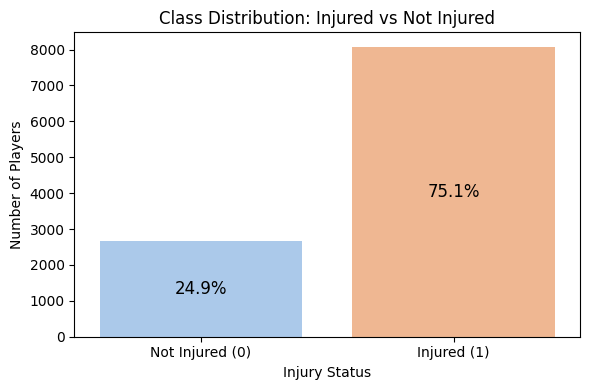

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count and percentage of each class
injury_counts = df['Injured'].value_counts()
injury_percentages = df['Injured'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Injured', hue='Injured', data=df, palette='pastel', legend=False)
plt.title('Class Distribution: Injured vs Not Injured')
plt.xticks([0, 1], ['Not Injured (0)', 'Injured (1)'])
plt.ylabel('Number of Players')
plt.xlabel('Injury Status')

# Annotate percentages at the center of each bar
for bar, percentage in zip(ax.patches, injury_percentages.sort_index()):
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    y = height / 2
    ax.text(x, y, f"{percentage:.1f}%", ha='center', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()




In [ ]:
# Extracting the year and month from the 'injury date' column
df['year'] = pd.DatetimeIndex(df['Injured Date']).year
df['month'] = pd.DatetimeIndex(df['Injured Date']).month
df

,PLAYER_ID,PLAYER_NAME,SEASON,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,REB,PTS,...,Returned Date,Days Missed,Injury Type,Notes,Out Indefinitely,body_part,SEASON_NUM,Injured,year,month
0,201985,AJ Price,2013-14,27.0,74.0,195.0,28,3.5,0.4,1.6,...,NaN,NaN,NaN,NaN,0,Others,13.5,0,NaN,NaN
1,201166,Aaron Brooks,2013-14,29.0,72.0,161.0,72,21.6,1.9,9.0,...,NaN,NaN,NaN,NaN,0,Others,13.5,0,NaN,NaN
2,201189,Aaron Gray,2013-14,29.0,84.0,270.0,37,9.6,3.0,1.8,...,NaN,NaN,NaN,NaN,0,Others,13.5,0,NaN,NaN
3,203519,Adonis Thomas,2013-14,21.0,79.0,240.0,6,6.3,0.5,2.3,...,NaN,NaN,NaN,NaN,0,Others,13.5,0,NaN,NaN
4,1733,Al Harrington,2013-14,34.0,81.0,245.0,34,15.0,2.4,6.6,...,2014-02-22,75.0,knee,placed on IL recovering from arthroscopic surg...,0,Leg,13.5,1,2013.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10742,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,2024-01-10,3.0,leg,placed on IL with bruised leg,0,Leg,23.5,1,2024.0,1.0
10743,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,2024-01-27,1.0,foot,bruised left foot (DTD),0,Foot,23.5,1,2024.0,1.0
10744,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,2024-02-02,2.0,foot,placed on IL with bruised left foot,0,Foot,23.5,1,2024.0,1.0
10745,1629627,Zion Williamson,2023-24,23.0,78.0,284.0,70,31.5,5.8,22.9,...,2024-02-12,2.0,foot,placed on IL with bruised left foot,0,Foot,23.5,1,2024.0,2.0


In [ ]:
numeric_columns = ['PLAYER_HEIGHT_INCHES', 'GP', 'PLAYER_WEIGHT', 'POSS', 'DIST_MILES', 'AVG_SPEED', 'PULL_UP_FGA']
for col in numeric_columns:
  df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
na_counts = df.isna().sum()[df.isna().sum()> 0]
print(na_counts)

PLAYER_HEIGHT_INCHES       5
PLAYER_WEIGHT              5
DIST_MILES                 1
AVG_SPEED                  1
DIST_MILES_OFF             1
DIST_MILES_DEF             1
AVG_SPEED_OFF              1
AVG_SPEED_DEF              1
PULL_UP_FG3A             828
Injured Date            2671
Returned Date           2671
Days Missed             2671
Injury Type             2671
Notes                   2671
year                    2671
month                   2671
dtype: int64


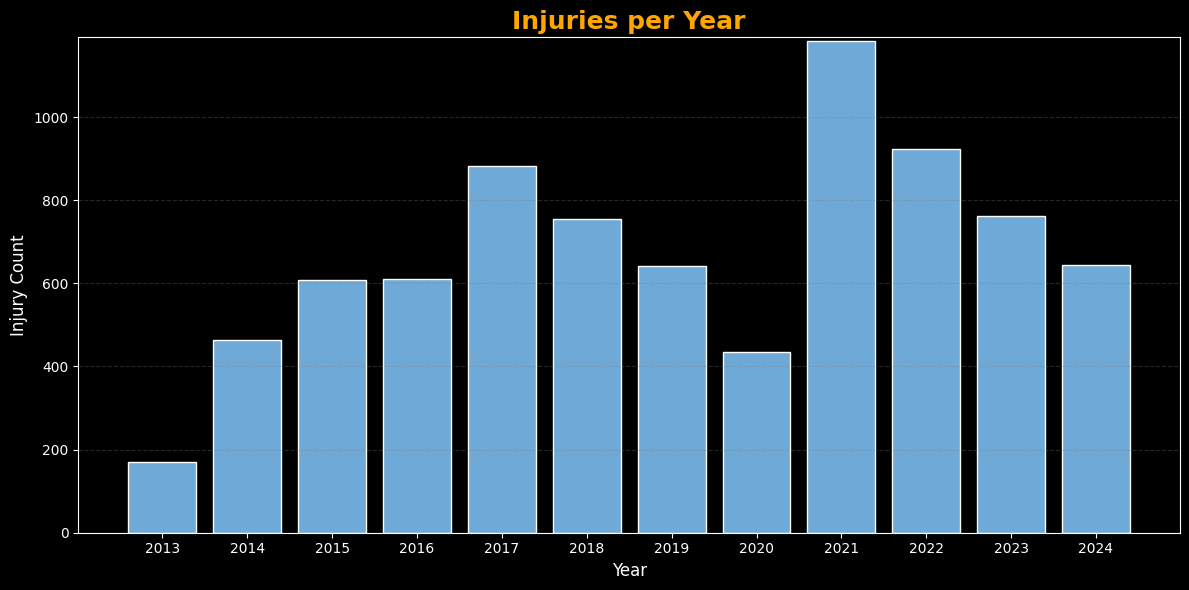

In [ ]:
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec

df_viz = df.copy()
df_viz['Injured Date'] = pd.to_datetime(df_viz['Injured Date'], errors='coerce')
df_viz['year'] = df_viz['Injured Date'].dt.year
df_viz['month'] = df_viz['Injured Date'].dt.month
df_viz = df_viz[df_viz['year'].notna()]


injuries_per_year = df_viz.groupby(df_viz['year'].astype(int)).size()

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(injuries_per_year.index, injuries_per_year.values, color='#6ea9d7', edgecolor='white')

ax.set_title('Injuries per Year', fontsize=18, color='orange', weight='bold')
ax.set_xlabel('Year', fontsize=12, color='white')
ax.set_ylabel('Injury Count', fontsize=12, color='white')
ax.set_xticks(injuries_per_year.index)
ax.set_xticklabels(injuries_per_year.index, rotation=0, color='white')
ax.tick_params(axis='y', colors='white')
ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray')

max_val = injuries_per_year.max()
ax.set_ylim(0, max_val + 10)

plt.tight_layout()
plt.show()



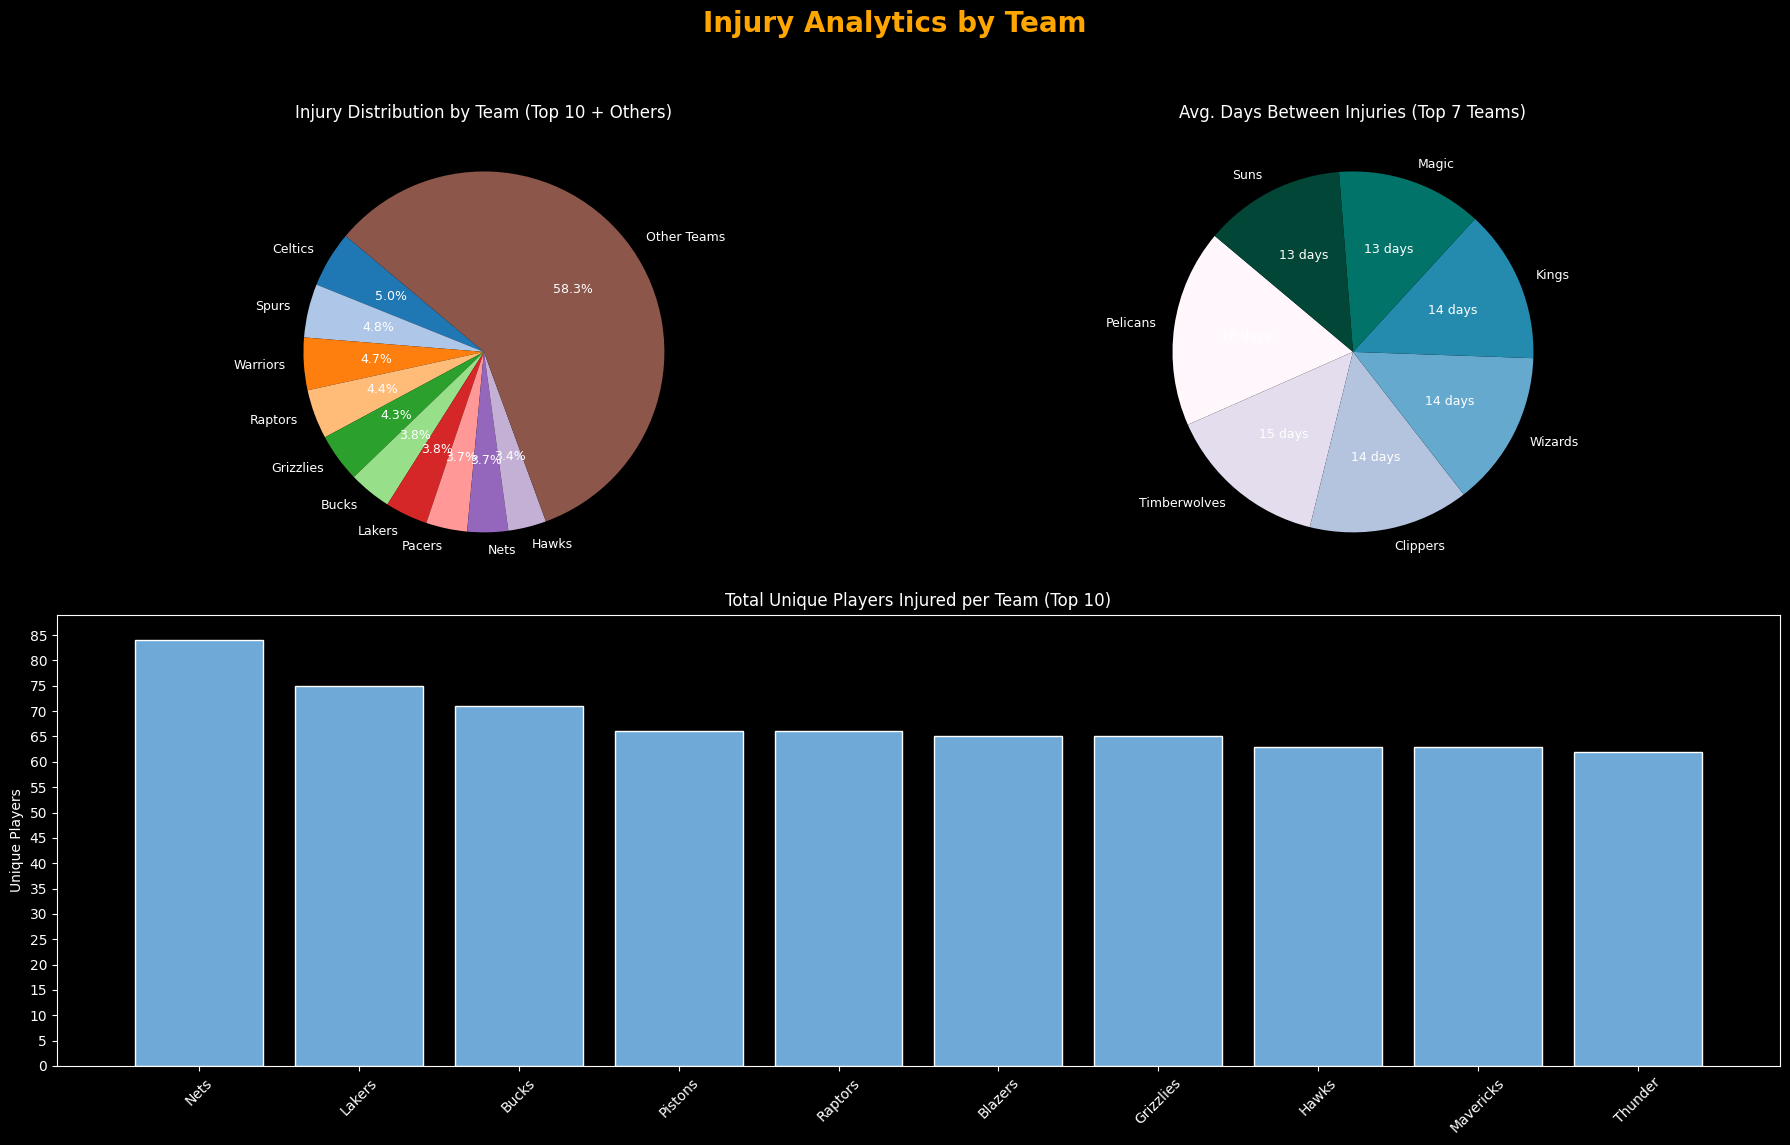

In [ ]:
plt.style.use('dark_background')

injuries_by_team = df_viz['TEAM'].value_counts()

top_teams = injuries_by_team.head(10)
other_total = injuries_by_team.iloc[10:].sum()
labels = list(top_teams.index) + ['Other Teams']
sizes = list(top_teams.values) + [other_total]

df_sorted = df_viz.copy()
df_sorted['Injured Date'] = pd.to_datetime(df_sorted['Injured Date'], errors='coerce')
df_sorted = df_sorted.sort_values(['TEAM', 'Injured Date'])
df_sorted['days_between'] = df_sorted.groupby('TEAM')['Injured Date'].diff().dt.days

avg_days_by_team = df_sorted.groupby('TEAM')['days_between'].mean().dropna().sort_values(ascending=False).head(7)

players_per_team = df_viz.groupby('TEAM')['PLAYER_NAME'].nunique().sort_values(ascending=False).head(10)

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, figure=fig)
fig.suptitle("Injury Analytics by Team", fontsize=20, color='orange', fontweight='bold')

# Pie chart: Injury distribution by team
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.tab20.colors,
        textprops={'color': 'white', 'fontsize': 9})
ax1.set_title("Injury Distribution by Team (Top 10 + Others)", color='white')

# Pie chart: Avg. days between injuries
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(avg_days_by_team,
        labels=avg_days_by_team.index,
        autopct='%1.0f days',
        startangle=140,
        colors=plt.get_cmap('PuBuGn')(np.linspace(0, 1, len(avg_days_by_team))),
        textprops={'color': 'white', 'fontsize': 9})
ax2.set_title("Avg. Days Between Injuries (Top 7 Teams)", color='white')

# Bar chart: Unique players injured per team
ax3 = fig.add_subplot(gs[1, :])
bars = ax3.bar(players_per_team.index, players_per_team.values, color='#6ea9d7', edgecolor='white')

max_val = max(players_per_team.values)
ax3.set_yticks(np.arange(0, max_val + 6, 5))
ax3.set_ylim(0, max_val + 5)

ax3.set_title("Total Unique Players Injured per Team (Top 10)", color='white')
ax3.set_ylabel("Unique Players", color='white')
ax3.tick_params(axis='x', rotation=45, colors='white')
ax3.tick_params(axis='y', colors='white')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



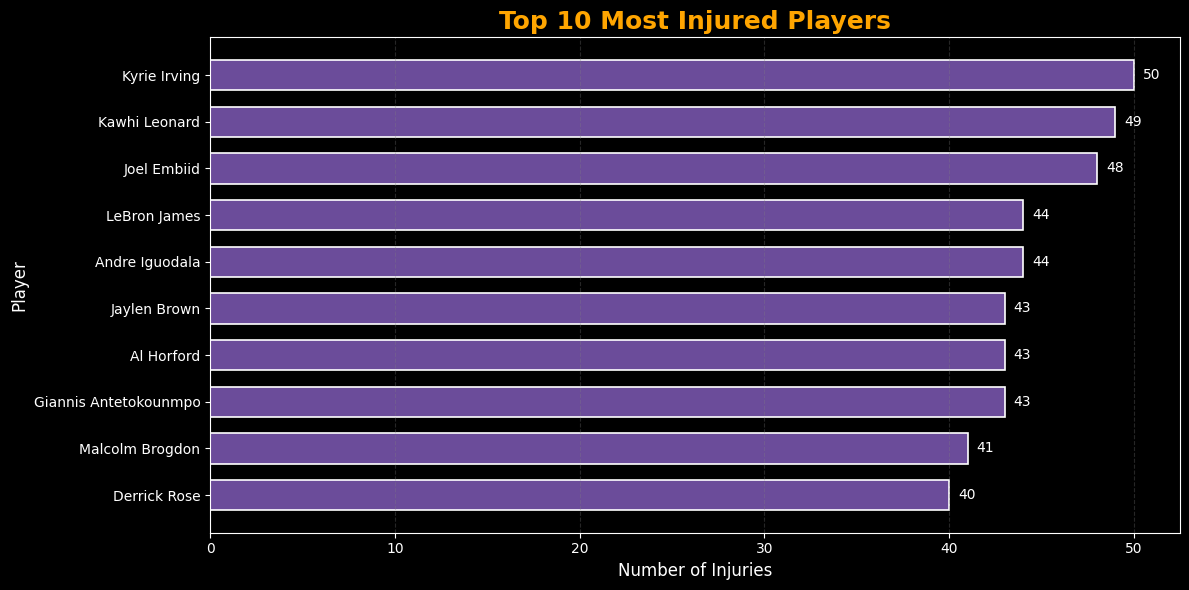

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Use df_viz instead of df
top_injured_players = df_viz['PLAYER_NAME'].value_counts().nlargest(10)

plt.style.use('dark_background')

bar_color = '#6b4c9a'

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(
    top_injured_players.index,
    top_injured_players.values,
    color=bar_color,
    edgecolor='white',
    linewidth=1.2,
    height=0.65
)

ax.invert_yaxis()

# Add drop shadow behind each bar
for bar in bars:
    shadow = patches.Rectangle(
        (bar.get_x() + 0.2, bar.get_y() - 0.05),
        bar.get_width(),
        bar.get_height(),
        color='black',
        alpha=0.2,
        zorder=0
    )
    ax.add_patch(shadow)

ax.set_title('Top 10 Most Injured Players', fontsize=18, color='orange', weight='bold')
ax.set_xlabel('Number of Injuries', fontsize=12, color='white')
ax.set_ylabel('Player', fontsize=12, color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.grid(axis='x', linestyle='--', alpha=0.3, color='gray')

# Add labels on bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
            f'{int(width)}', va='center', color='white', fontsize=10)

plt.tight_layout()
plt.show()


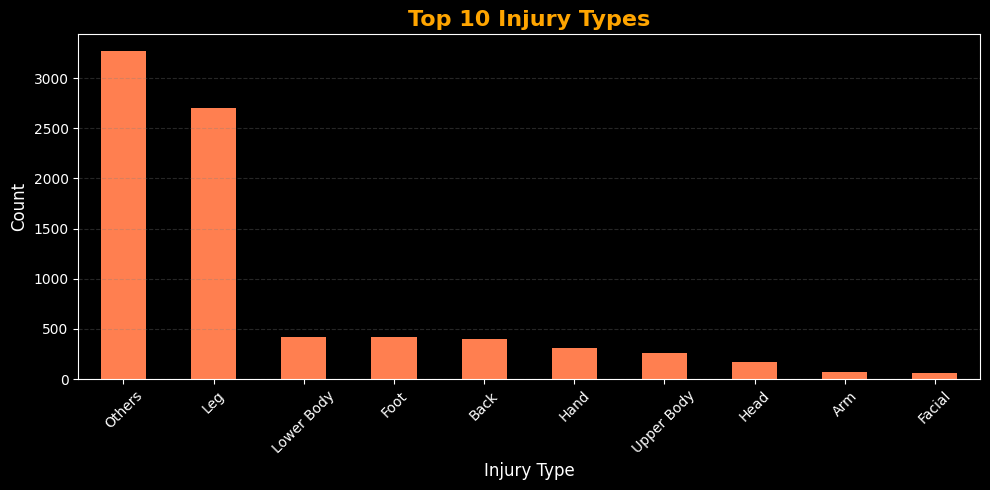

In [ ]:
import matplotlib.pyplot as plt

# Use dark background style
plt.style.use('dark_background')

# Count top 10 injury types using df_viz
top_10_injuries = df_viz['body_part'].value_counts().head(10)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
top_10_injuries.plot(
    kind='bar',
    color='#ff7f50',
    ax=ax
)

# Styling
ax.set_title('Top 10 Injury Types', color='orange', fontsize=16, weight='bold')
ax.set_xlabel('Injury Type', color='white', fontsize=12)
ax.set_ylabel('Count', color='white', fontsize=12)
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')
ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray')

plt.tight_layout()
plt.show()



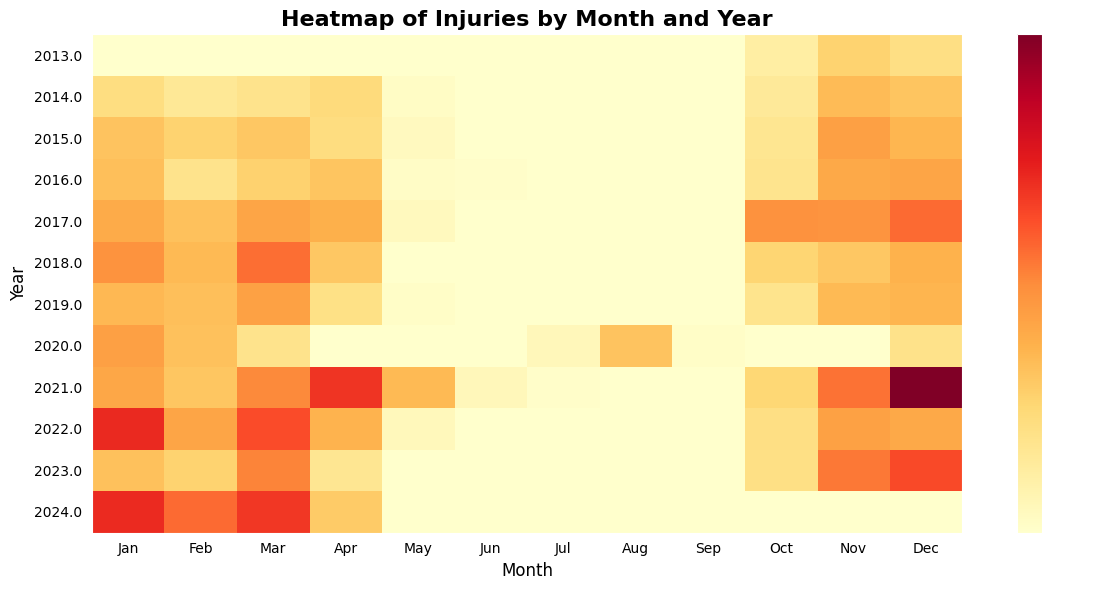

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create pivot table
pivot = df_viz.pivot_table(index='year', columns='month', values='Injury Type', aggfunc='count', fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
plt.imshow(pivot, cmap='YlOrRd', aspect='auto')

# Add colorbar
plt.colorbar(label='Injury Count')

# Set axis ticks and labels
plt.xticks(
    ticks=np.arange(12),
    labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
    fontsize=10,
    color='black'
)
plt.yticks(
    ticks=np.arange(len(pivot.index)),
    labels=pivot.index,
    fontsize=10,
    color='black'
)

# Titles and labels
plt.title('Heatmap of Injuries by Month and Year', fontsize=16, weight='bold', color='black')
plt.xlabel('Month', fontsize=12, color='black')
plt.ylabel('Year', fontsize=12, color='black')

# Set white background
plt.gca().set_facecolor('white')
plt.gcf().patch.set_facecolor('white')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Corrected to consistently use df_viz
kyrie_df = df_viz[df_viz['PLAYER_NAME'] == 'Kyrie Irving'].copy()

kyrie_df['Injured Date'] = pd.to_datetime(kyrie_df['Injured Date'], errors='coerce')
kyrie_df['year'] = kyrie_df['Injured Date'].dt.year
kyrie_df['month'] = kyrie_df['Injured Date'].dt.month

kyrie_df = kyrie_df[kyrie_df['Injured Date'].notna()]

# Compute metrics
total_injuries = len(kyrie_df)
body_part_counts = kyrie_df['body_part'].value_counts()
injuries_by_year = kyrie_df['year'].value_counts().sort_index()
avg_month = int(kyrie_df['month'].mean()) if not kyrie_df['month'].isna().all() else None
out_indefinitely_pct = kyrie_df['Out Indefinitely'].mean() * 100 if 'Out Indefinitely' in kyrie_df.columns else None

# Sort for additional insights
kyrie_df_sorted = kyrie_df.sort_values('Injured Date')
kyrie_df_sorted['days_between'] = kyrie_df_sorted['Injured Date'].diff().dt.days

# Create pivot for heatmap
heatmap_data = kyrie_df.pivot_table(
    index='year',
    columns='month',
    values='Injury Type',
    aggfunc='count',
    fill_value=0
)



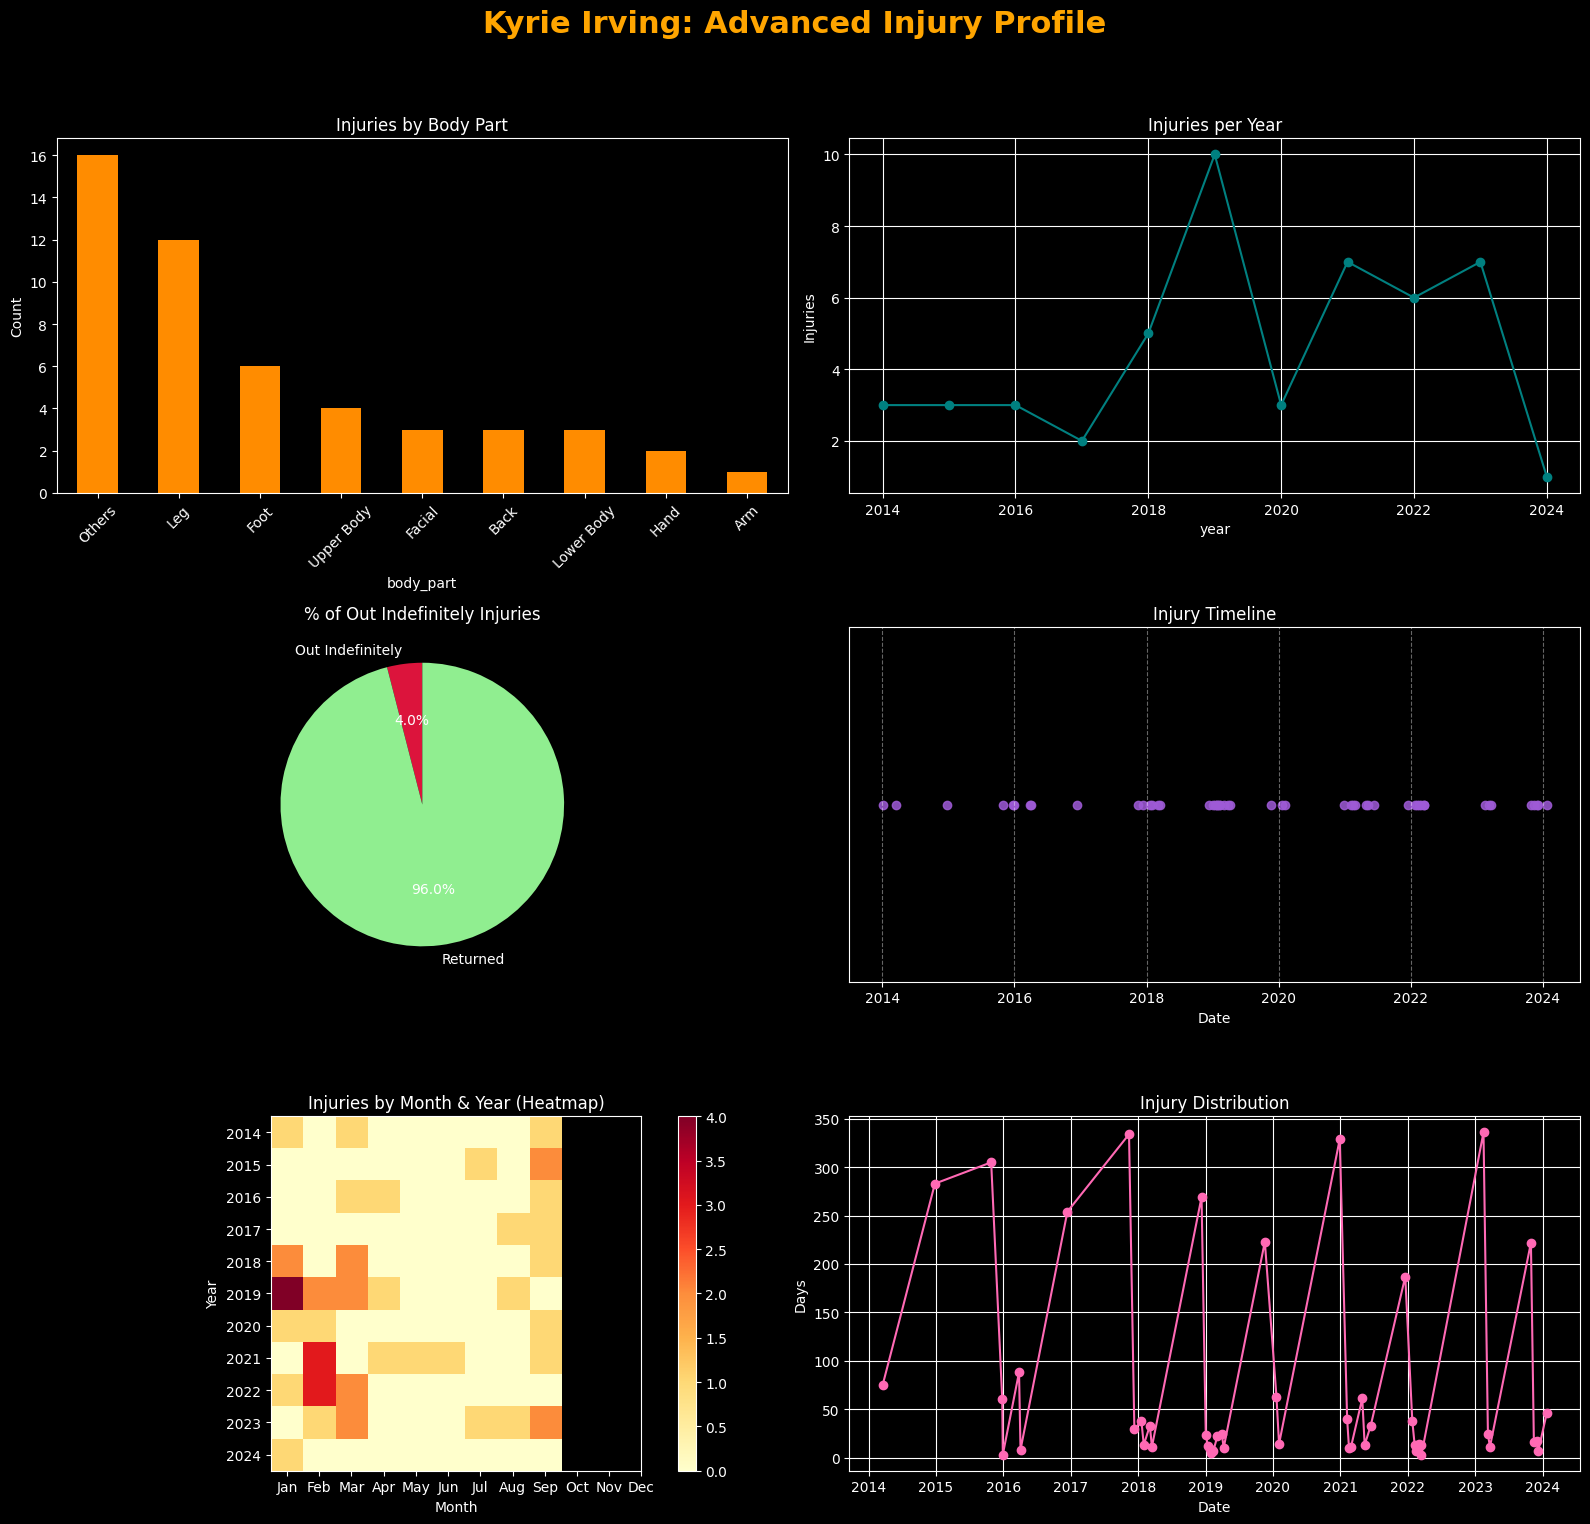

<ipython-input-24-698574cfcd75>:129: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


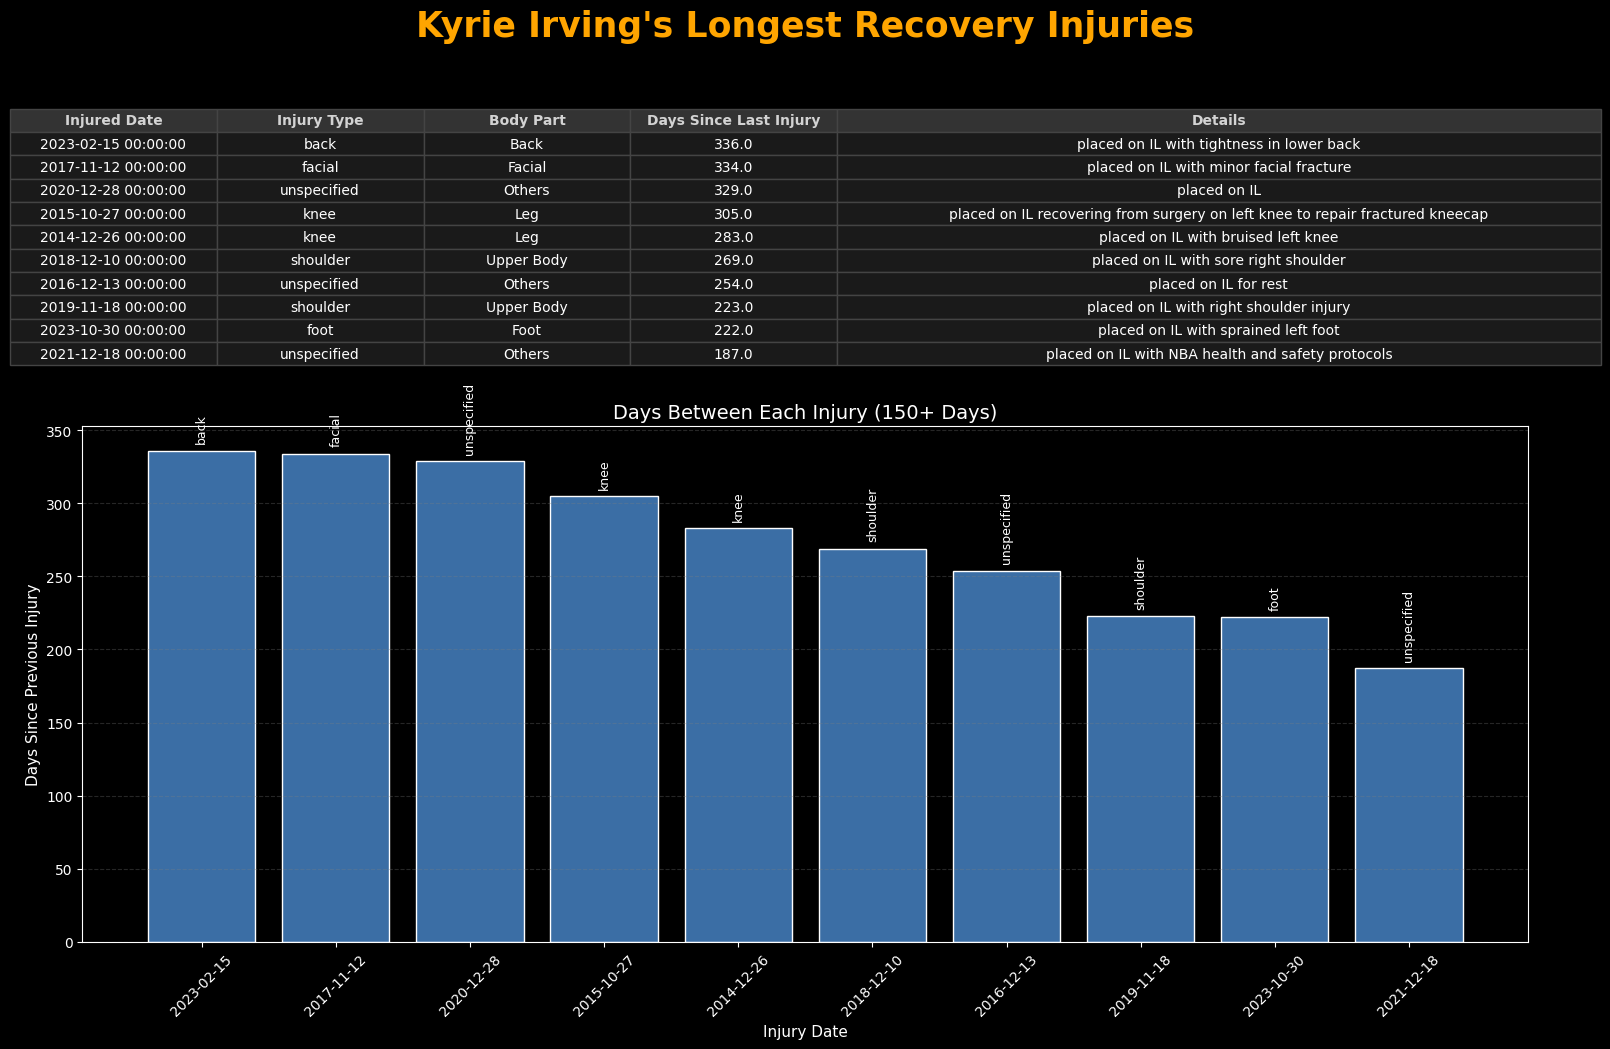

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

plt.style.use('dark_background')

# -- Main injury profile --

fig, axs = plt.subplots(3, 2, figsize=(16, 16))
fig.suptitle("Kyrie Irving: Advanced Injury Profile", fontsize=22, fontweight='bold', color='orange')

body_part_counts.plot(kind='bar', ax=axs[0, 0], color='darkorange')
axs[0, 0].set_title('Injuries by Body Part', color='white')
axs[0, 0].set_ylabel('Count')
axs[0, 0].tick_params(axis='x', rotation=45, colors='white')
axs[0, 0].tick_params(axis='y', colors='white')

injuries_by_year.plot(marker='o', ax=axs[0, 1], color='teal')
axs[0, 1].set_title('Injuries per Year', color='white')
axs[0, 1].set_ylabel('Injuries')
axs[0, 1].grid(True)
axs[0, 1].tick_params(axis='x', colors='white')
axs[0, 1].tick_params(axis='y', colors='white')

if out_indefinitely_pct is not None:
    axs[1, 0].pie(
        [out_indefinitely_pct, 100 - out_indefinitely_pct],
        labels=['Out Indefinitely', 'Returned'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['crimson', 'lightgreen'],
        textprops={'color': 'white'}
    )
    axs[1, 0].set_title('% of Out Indefinitely Injuries', color='white')
else:
    axs[1, 0].text(0.5, 0.5, 'No Out Indefinitely Data', ha='center', color='white')
    axs[1, 0].axis('off')

axs[1, 1].scatter(kyrie_df_sorted['Injured Date'], [1]*len(kyrie_df_sorted), color='#9f5bd7', alpha=0.85)
axs[1, 1].set_yticks([])
axs[1, 1].set_title('Injury Timeline', color='white')
axs[1, 1].set_xlabel('Date', color='white')
axs[1, 1].grid(True, axis='x', linestyle='--', alpha=0.4)
axs[1, 1].tick_params(axis='x', colors='white')

im = axs[2, 0].imshow(heatmap_data, cmap='YlOrRd')
axs[2, 0].set_title('Injuries by Month & Year (Heatmap)', color='white')
axs[2, 0].set_xlabel('Month', color='white')
axs[2, 0].set_ylabel('Year', color='white')
axs[2, 0].set_xticks(np.arange(12))
axs[2, 0].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], color='white')
axs[2, 0].set_yticks(np.arange(len(heatmap_data.index)))
axs[2, 0].set_yticklabels(heatmap_data.index, color='white')
plt.colorbar(im, ax=axs[2, 0])

axs[2, 1].plot(kyrie_df_sorted['Injured Date'], kyrie_df_sorted['days_between'], marker='o', color='#ff69b4')
axs[2, 1].set_title('Injury Distribution', color='white')
axs[2, 1].set_xlabel('Date', color='white')
axs[2, 1].set_ylabel('Days', color='white')
axs[2, 1].grid(True)
axs[2, 1].tick_params(axis='x', colors='white')
axs[2, 1].tick_params(axis='y', colors='white')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



kyrie_df = df_viz[df_viz['PLAYER_NAME'] == 'Kyrie Irving'].copy()
kyrie_df['Injured Date'] = pd.to_datetime(kyrie_df['Injured Date'], errors='coerce')
kyrie_df = kyrie_df.sort_values('Injured Date')
kyrie_df['days_between'] = kyrie_df['Injured Date'].diff().dt.days

long_recovery_df = kyrie_df[kyrie_df['days_between'] > 150].copy()
long_recovery_df = long_recovery_df[['Injured Date', 'Injury Type', 'body_part', 'days_between', 'Notes']]
long_recovery_df.columns = ['Injured Date', 'Injury Type', 'Body Part', 'Days Since Last Injury', 'Details']
long_recovery_df = long_recovery_df.sort_values('Days Since Last Injury', ascending=False).reset_index(drop=True)

fig = plt.figure(constrained_layout=True, figsize=(16, 11))
gs = GridSpec(3, 2, figure=fig)
fig.suptitle("Kyrie Irving's Longest Recovery Injuries",
             fontsize=25, fontweight='bold', color='orange')

ax_table = fig.add_subplot(gs[:1, :])
ax_table.axis('off')

table = ax_table.table(cellText=long_recovery_df.values,
                       colLabels=long_recovery_df.columns,
                       loc='center',
                       cellLoc='center',
                       colColours=['#1c1c1c']*5,
                       colWidths=[0.13, 0.13, 0.13, 0.13, 0.48])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.1, 1.6)

for key, cell in table.get_celld().items():
    cell.set_edgecolor('#444')
    if key[0] == 0:
        cell.set_text_props(weight='bold', color='lightgray')
        cell.set_facecolor('#333')
    else:
        cell.set_facecolor('#1a1a1a')
        cell.set_text_props(color='white')

ax_chart = fig.add_subplot(gs[1:, :])
bar_color = '#3b6ea5'

bars = ax_chart.bar(
    long_recovery_df['Injured Date'].dt.strftime('%Y-%m-%d'),
    long_recovery_df['Days Since Last Injury'],
    color=bar_color,
    edgecolor='white'
)

for bar, injury_type in zip(bars, long_recovery_df['Injury Type']):
    height = bar.get_height()
    ax_chart.text(bar.get_x() + bar.get_width()/2, height + 5,
                  injury_type, ha='center', va='bottom', fontsize=9, color='white', rotation=90)

ax_chart.set_title("Days Between Each Injury (150+ Days)", fontsize=14, color='white')
ax_chart.set_xlabel("Injury Date", fontsize=11)
ax_chart.set_ylabel("Days Since Previous Injury", fontsize=11)
ax_chart.set_xticks(range(len(long_recovery_df)))
ax_chart.set_xticklabels(long_recovery_df['Injured Date'].dt.strftime('%Y-%m-%d'), rotation=45)
ax_chart.grid(axis='y', linestyle='--', alpha=0.3, color='gray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


##Imputing missing values with mean

In [ ]:
# deal with null values by imputing their values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
cols = ['PLAYER_WEIGHT', 'PLAYER_HEIGHT_INCHES','DIST_MILES','AVG_SPEED',
        'PULL_UP_FGA', 'DIST_MILES_OFF', 'DIST_MILES_DEF',
        'AVG_SPEED_OFF', 'AVG_SPEED_DEF', 'PULL_UP_FG3A']

df.loc[:, cols] = imputer.fit_transform(df[cols])


### Input Features Description

The input features include a wide range of **biomechanical, workload, and performance indicators** sourced from NBA.com’s **tracking** and **advanced stats APIs**.

We dropped irrelevant identifiers and any columns **unavailable at prediction time**. The final features used fall into the following categories:

---

**1. Player Physical Attributes**
- `AGE`
- `PLAYER_HEIGHT_INCHES`
- `PLAYER_WEIGHT`

**2. Workload & Usage**
- `MIN`
- `USG_PCT`
- `PACE`
- `POSS`
- `FGA_PG`

**3. Movement Tracking**
- `DIST_MILES`
- `AVG_SPEED`
- `TOUCHES`
- `DRIVES`
- `PULL_UP_FGA`

**4. Touch & Shot Profiles**
- `FRONT_CT_TOUCHES`
- `AVG_SEC_PER_TOUCH`
- `POST_TOUCHES`
- `ELBOW_TOUCHES`
- *(additional similar features)*

**5. Season Context**
- `SEASON_NUM` — Indicates which season the player is in (e.g., rookie vs. veteran years)

---

**Total features after preprocessing**: **44**
---

**Target Variable: Injured**

The target variable is a binary indicator:
1 → The player missed time due to an injury in that season
0 → The player did not suffer any recorded injury that season


In [ ]:
# Preparing the features and the target variable
y= df['Injured']
x= df.drop(columns = ['Injured','PLAYER_NAME', 'SEASON','PLAYER_ID',
                                     'SEASON_NUM', 'TEAM',
                                     'Returned Date', 'Days Missed',
                                     'Notes', 'Out Indefinitely', 'Injury Type',
                                     'body_part', 'Injured Date', 'year', 'month','TEAM_ABBREVIATION'] , axis=1)
RANDOM_SEED = 42 # consistent across all model runs

X_train, X_test, Y_train, Y_test= train_test_split(x, y, test_size= 0.20, stratify=y,random_state=RANDOM_SEED)

In [93]:
x.shape

(10747, 44)

##Scaling to ensure all features contribute equally


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled_array= scaler.fit_transform(X_train)
X_test_scaled_array = scaler.transform(X_test)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns, index=X_test.index)

# Logistic Regression


*   Used here because it can capture linear relationships between workload performance indicators and injury occurence


### Logistic Regression with Regularization and Grid Search

Logistic Regression was applied using a range of regularization options to determine the best-performing model configuration. Specifically, three penalty types were evaluated:

- `none`: No regularization applied.
- `l1`: Lasso regularization, which can perform feature selection by shrinking some coefficients to zero.
- `l2`: Ridge regularization, which helps prevent overfitting by penalizing large coefficients.

A grid search was used to tune the hyperparameters:
- `C`: The inverse of regularization strength, tested across a logarithmic range from 0.01 to 100.
- `solver`: Included solvers compatible with `l1` and `l2` penalties (`liblinear`, `saga`).
- `penalty`: Evaluated `none`, `l1`, and `l2` as regularization strategies.

The model was trained using 5-fold cross-validation, with the **F1-score** used as the evaluation metric to ensure a balance between precision and recall. This choice was particularly important due to the moderate class imbalance in the dataset and the goal of minimizing false negatives.

The best model selected by GridSearchCV was then evaluated on the test set using accuracy and F1-score.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

# Define the model
logreg = LogisticRegression(random_state=RANDOM_SEED, max_iter=20000, class_weight='balanced')

# Define the hyperparameter grid
param_grid = [
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']},
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']},
    {'penalty': [None], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga']}
]


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1-score
    cv=5,          # 5-fold cross-validation
    n_jobs=-1      # Use all processors
)

# Fit the model
grid_search.fit(X_train_scaled, Y_train)

# Get best model
best_logreg_balanced = grid_search.best_estimator_

# Make predictions
Y_pred_balanced = best_logreg_balanced.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(Y_test, Y_pred_balanced)
f1 = f1_score(Y_test, Y_pred_balanced)

# Print results
print(f'Best Params: {grid_search.best_params_}')
print(f'Best Cross-Validated F1-Score: {grid_search.best_score_:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'Test F1-Score: {f1:.4f}')


Best Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validated F1-Score: 0.6679
Test Accuracy: 58.37%
Test F1-Score: 0.6679


### Logistic Regression (Grid Search) Performance Summary

- F1-score for injury class (1) is **0.67**, but recall is only **0.56**, indicating the model misses many injury cases.
- Overall performance is poor (**accuracy = 58.37%**), and the model struggles with both precision and balance, making it unsuitable for minimizing false negatives.


In [ ]:
print(classification_report(Y_test,Y_pred_balanced))

              precision    recall  f1-score   support

           0       0.33      0.66      0.44       534
           1       0.83      0.56      0.67      1616

    accuracy                           0.58      2150
   macro avg       0.58      0.61      0.56      2150
weighted avg       0.71      0.58      0.61      2150



#Logistic Regression with no penalties
**Note**- The `class_weight` param is `None` here.
Notice the higher accuracy but such a poor f1-score **(0.12)** for class 0.
This shows accuracy is a misleading metric for the injury classification use-case.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

# Define the model
log_reg_unbalanced = LogisticRegression(random_state=RANDOM_SEED, max_iter=20000,solver = 'liblinear')

# Fit the model
log_reg_unbalanced.fit(X_train_scaled, Y_train)

# Make predictions
Y_pred_unbalanced= log_reg_unbalanced.predict(X_test_scaled)
log_reg_unbalanced_score = log_reg_unbalanced.score(X_test_scaled, Y_test)
print(f"Logistic Regression score on test data: {log_reg_unbalanced_score*100:.2f}%")
print(classification_report(Y_pred_unbalanced,Y_test))

              precision    recall  f1-score   support

           0       0.07      0.81      0.12        43
           1       1.00      0.76      0.86      2107

    accuracy                           0.76      2150
   macro avg       0.53      0.79      0.49      2150
weighted avg       0.98      0.76      0.85      2150



#Decision Tree Classifier


*   Used here because it can learn non-linear decison rules,ideal for mixed features types (e.g. speed,touches,age)



A Decision Tree classifier was used with `class_weight='balanced'` to account for the moderate class imbalance in the dataset.
To find the optimal set of hyperparameters, a GridSearchCV was performed with 5-fold cross-validation. The following hyperparameters were tuned:

- `criterion`: The function used to measure the quality of a split (`'gini'` or `'entropy'`)
- `max_depth`: The maximum depth of the tree (tested values: 1, 2, 3)
- `min_samples_split`: The minimum number of samples required to split an internal node (2, 5, or 10)
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node (1, 2, or 4)

The evaluation metric used during hyperparameter tuning was the **F1-score**, which balances precision and recall and is more appropriate than accuracy in imbalanced classification problems.

The best-performing model was selected based on the highest average F1-score across the cross-validation folds. The final model was then visualized using `plot_tree()` to examine its structure.

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best model score on test data: 0.8685380259580988


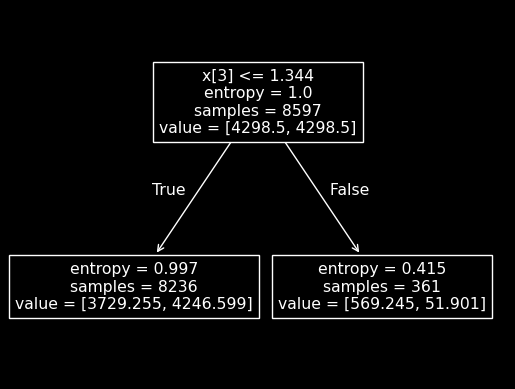

In [ ]:
# instantiates model class
clf= DecisionTreeClassifier(random_state=RANDOM_SEED,class_weight='balanced')


# dictionary with different hyperparameters for GridSearchCV to look through and
# find optimal params
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1,2,3],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1, 2, 4]
}

# function that searches for optimal hyperparameters to optimize accuracy
gsTree= GridSearchCV(clf, param_grid=params, scoring='f1',
             cv=5)

gsTree.fit(X_train_scaled, Y_train)

bestParams= gsTree.best_params_
bestScore= gsTree.best_score_
bestModel_dt= gsTree.best_estimator_

print(f"Best hyperparameters: {bestParams}")
print(f"Best model score on test data: {bestScore}")

# print out best tree

plot_tree(bestModel_dt)
plt.show()

### Decision Tree Performance Summary

- Achieved a strong F1-score of **0.87** and recall of **0.99** for injury cases, indicating the model is highly effective at detecting injuries.
- However, performance on non-injury cases is poor (F1-score = **0.22**, recall = **0.13**), suggesting the model heavily favors the majority class.


In [ ]:
dt_report = classification_report(Y_test, bestModel_dt.predict(X_test_scaled))
print(dt_report)

              precision    recall  f1-score   support

           0       0.85      0.12      0.20       534
           1       0.77      0.99      0.87      1616

    accuracy                           0.78      2150
   macro avg       0.81      0.55      0.54      2150
weighted avg       0.79      0.78      0.70      2150



# Bagging Classifier with Decision Trees
* Used here because it reduces variance by averaging across many decision trees trained on bootstraped samples

* Bagging Classifier was trained using grid Search to find the best parameters.

**100** Decision Trees provided the best f1-score - **0.80**

**Note:** Class weights were not explicitly balanced in the base estimator, as bagging with a sufficiently large number of estimators tends to reduce overfitting and can inherently handle moderate class imbalance through averaging over diverse trees.


In [95]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define model
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=RANDOM_SEED
)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 150],
    'estimator__max_depth': [None, 5, 10]
}

# Use weighted F1 as scoring metric
f1_scorer = make_scorer(f1_score, average='weighted')

# Grid search with default 5-fold CV
grid_search = GridSearchCV(
    estimator=bagging_clf,
    param_grid=param_grid,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_scaled, Y_train)

# Output best results
print("Best F1 Score: ", grid_search.best_score_)
print("Best Parameters: ", grid_search.best_params_)




Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best F1 Score:  0.8022152431183736
Best Parameters:  {'estimator__max_depth': None, 'n_estimators': 150}


### Bagging Classifier Performance Summary

- Achieved balanced F1-scores across classes: **0.62 (non-injury)** and **0.90 (injury)**.
- Maintained **high recall (0.96) for injury cases**, effectively minimizing false negatives.
.


In [96]:
best_model_bagging = grid_search.best_estimator_

# 8. Predict on the test set
y_pred = best_model_bagging.predict(X_test_scaled)

# 9. Evaluation metrics
print("BestF1 Score:", grid_search.best_score_)
print("Test Accuracy:", accuracy_score(Y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))
print("Classification Report:\n", classification_report(Y_test, y_pred))


BestF1 Score: 0.8022152431183736
Test Accuracy: 0.8344186046511628
Confusion Matrix:
 [[ 248  286]
 [  70 1546]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.46      0.58       534
           1       0.84      0.96      0.90      1616

    accuracy                           0.83      2150
   macro avg       0.81      0.71      0.74      2150
weighted avg       0.83      0.83      0.82      2150



#XGBoost Classifier


*   Used here because it can handle non-linear patterns and feature interactions exceptionally well, especially with high-dimensional inputs
* Inbuilt feature selection helps to reduce overfitting



In [ ]:
# Fit the model
xgbClassifier_normal = XGBClassifier(random_state=RANDOM_SEED)
xgbClassifier_normal.fit(X_train_scaled, Y_train)

# Predict on test data
y_pred = xgbClassifier_normal.predict(X_test_scaled)



### XGBoost Classifier Performance Summary

- Achieved a high F1-score of **0.90** and recall of **0.95** for injury cases, indicating strong performance in minimizing false negatives.
- The model also performs reasonably well on non-injury cases (F1 = 0.59), with an overall accuracy of **84.3%** and balanced metrics across classes.


In [ ]:
# Accuracy
xgbScore = xgbClassifier_normal.score(X_test_scaled, Y_test)
print(f"XGBClassifier score on test data: {xgbScore*100:.2f}%")

# 🔍 Classification Report
print("Classification Report:\n")
print(classification_report(Y_test, y_pred))

XGBClassifier score on test data: 84.33%
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.49      0.61       534
           1       0.85      0.96      0.90      1616

    accuracy                           0.84      2150
   macro avg       0.83      0.73      0.76      2150
weighted avg       0.84      0.84      0.83      2150



### Handling Class Imbalance in XGBoost

To address the class imbalance in the dataset (with class 0 being the minority), the `scale_pos_weight` parameter was used in the XGBoost classifier. This parameter adjusts the weight of the minority class during training, making the model more sensitive to class 0 misclassifications.




In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Estimate imbalance
from collections import Counter
ratio = Counter(Y_train)[1] / Counter(Y_train)[0]  #Class 0 is minority

xgb_balanced = XGBClassifier(
    scale_pos_weight=ratio,
    eval_metric='auc',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    random_state=RANDOM_SEED
)

xgb_balanced.fit(X_train_scaled, Y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### XGBoost Classifier Performance Summary

- Achieved a lower  F1-score of **0.87** and recall of **0.78** for injury cases, indicating that penalties on class imbalance played a role
- The model performed worse as compared to XGBoost without penalties on non-injury cases (F1 = 0.24), with an overall accuracy of **78.19**.

The idea of applying penalties did not work well in this case.


In [ ]:
y_pred = xgb_balanced.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")
print(classification_report(Y_test, y_pred))

Accuracy: 78.19%
              precision    recall  f1-score   support

           0       0.88      0.14      0.24       534
           1       0.78      0.99      0.87      1616

    accuracy                           0.78      2150
   macro avg       0.83      0.57      0.56      2150
weighted avg       0.80      0.78      0.72      2150



#Random Forest Classifier
* Used here because aggregrates multiple trees to improve generalization and prevent overfitting, while capturing complexity

In [ ]:
rf_normal = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_SEED
)

rf_normal.fit(X_train_scaled, Y_train)
y_pred_normal = rf_normal.predict(X_test_scaled)



### Random Forest (No Class Balancing) Performance Summary

- The model performed very well on the injury class with an F1-score of **0.90** and recall of **0.95**, showing high effectiveness in detecting injuries even without explicit class weighting.
- It also handled the non-injury class better than most other models (F1-score = **0.58**, recall = **0.46**), resulting in a well-balanced performance with an overall accuracy of **83.3%**.


In [ ]:
print("📊 Random Forest (No Class Balancing)")
print("Accuracy:", accuracy_score(Y_test, y_pred_normal))
print("Classification Report:\n", classification_report(Y_test, y_pred_normal))

📊 Random Forest (No Class Balancing)
Accuracy: 0.8404651162790697
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.46      0.59       534
           1       0.84      0.97      0.90      1616

    accuracy                           0.84      2150
   macro avg       0.83      0.71      0.74      2150
weighted avg       0.84      0.84      0.82      2150



#Random Forest Classifier
This models penalises for incorrectly the minority class


In [ ]:
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',   # Adjusts weights inversely proportional to class frequencies
    random_state=RANDOM_SEED
)

rf_balanced.fit(X_train_scaled, Y_train)
y_pred_balanced = rf_balanced.predict(X_test_scaled)


### Random Forest (Balanced) Performance Summary

- The model achieved strong performance on the injury class with an F1-score of **0.89** and recall of **0.97**, indicating it correctly identifies most injury cases.
- Performance on the non-injury class improved over some other models, with an F1-score of **0.51**, reflecting a better balance while still prioritizing injury detection.


In [ ]:
print("\n📊 Random Forest (With Class Weight = 'balanced')")
print("Accuracy:", accuracy_score(Y_test, y_pred_balanced))
print("Classification Report:\n", classification_report(Y_test, y_pred_balanced))


📊 Random Forest (With Class Weight = 'balanced')
Accuracy: 0.8204651162790698
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.37      0.50       534
           1       0.82      0.97      0.89      1616

    accuracy                           0.82      2150
   macro avg       0.81      0.67      0.70      2150
weighted avg       0.82      0.82      0.79      2150



#Results

### Best Two Models Based on ROC-AUC

Based on the ROC-AUC analysis, the two best-performing models are:

1. **Random Forest (UnBalanced)**  
   - AUC Score: **0.94**  
   - Demonstrated the strongest overall ability to distinguish between injury and non-injury cases while accounting for class imbalance.

2. **Random Forest (Balanced)**  
   - AUC Score: **0.938**  
   - Performed nearly identically in terms of AUC and showed slightly better precision on the non-injury class in the classification report.

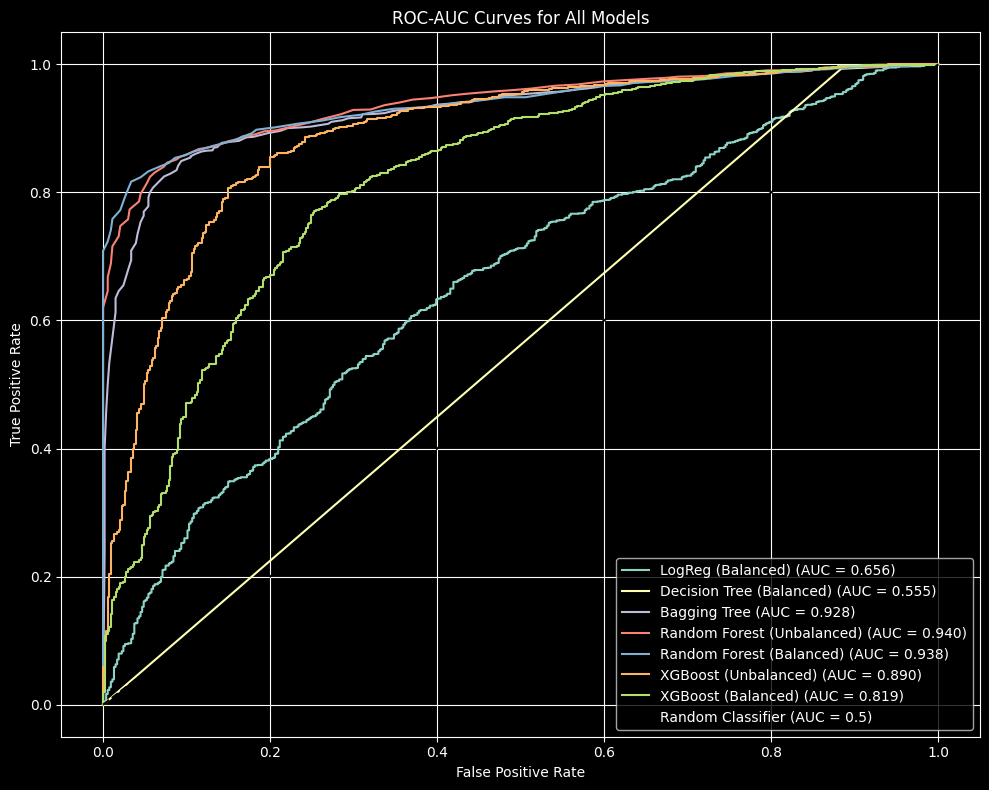

In [97]:
models = {
    "LogReg (Balanced)": best_logreg_balanced,
    "Decision Tree (Balanced)": bestModel_dt,
    "Bagging Tree": best_model_bagging,
    "Random Forest (Unbalanced)": rf_normal,
    "Random Forest (Balanced)": rf_balanced,
    "XGBoost (Unbalanced)": xgbClassifier_normal,
    "XGBoost (Balanced)": xgb_balanced
}
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test_scaled)
    else:
        continue

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(Y_test, y_scores)
    auc = roc_auc_score(Y_test, y_scores)

    # Plot
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

plt.title("ROC-AUC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



### Best Two Models Based on F1-Score

The chart below comparing F1-scores,precision,recall across all models highlights the top performers in balancing precision and recall:

1. **XGBoost (Unbalanced)**  
   - **F1 Score: 0.829**
   - **Precision 0.851**
   - **Recall 0.960**

2. **Random Forest (Unbalanced)**
    - **F1 Score: 0.823**
    - **Precision 0.844**
    - **Recall 0.967**





These two models demonstrate the best trade-off between minimizing false negatives and avoiding excessive false positives, making them top candidates for the best model


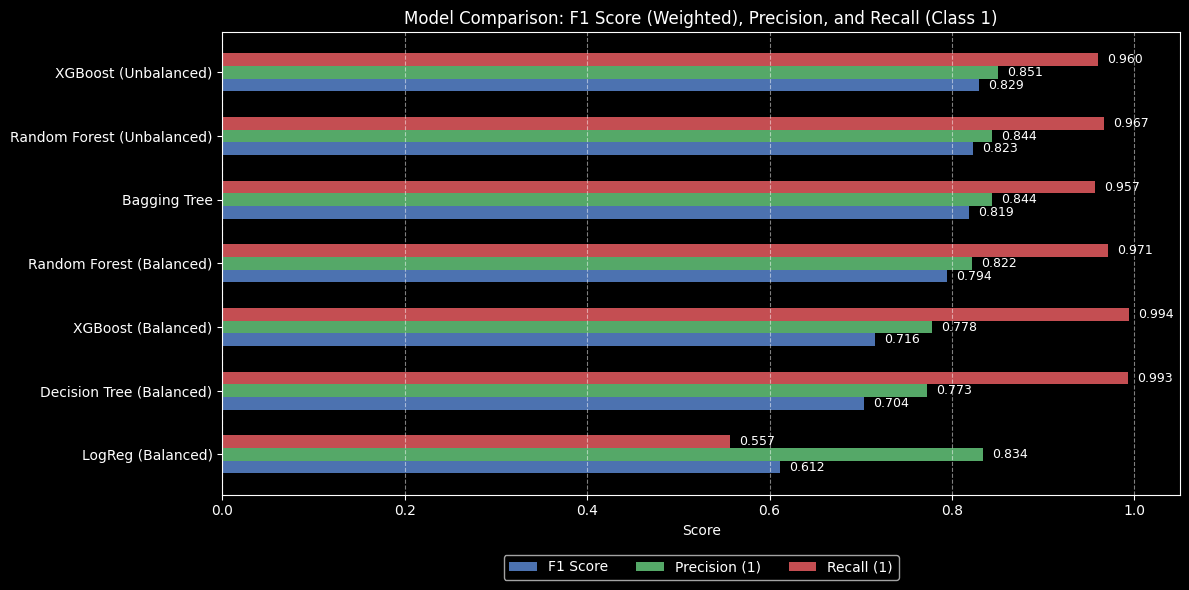

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score


metrics = {"F1 Score": {}, "Precision (1)": {}, "Recall (1)": {}}
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    metrics["F1 Score"][name] = f1_score(Y_test, y_pred, average='weighted')
    metrics["Precision (1)"][name] = precision_score(Y_test, y_pred, pos_label=1)
    metrics["Recall (1)"][name] = recall_score(Y_test, y_pred, pos_label=1)


metrics_df = pd.DataFrame(metrics)
metrics_df.sort_values("F1 Score", ascending=True, inplace=True)


bar_width = 0.2
indices = np.arange(len(metrics_df))
fig, ax = plt.subplots(figsize=(12, 6))


ordered_metrics = ["F1 Score", "Precision (1)", "Recall (1)"]
colors = ['#4c72b0', '#55a868', '#c44e52']


for i, (metric, color) in enumerate(zip(ordered_metrics, colors)):
    scores = metrics_df[metric]
    bars = ax.barh(indices + i * bar_width, scores, height=bar_width, label=metric, color=color)


    for bar in bars:
        width = bar.get_width()
        y_pos = bar.get_y() + bar.get_height() / 2
        ax.text(width + 0.01, y_pos, f"{width:.3f}", va='center', fontsize=9)

ax.set_yticks(indices + bar_width)
ax.set_yticklabels(metrics_df.index)
ax.set_xlabel("Score")
ax.set_xlim(0, 1.05)
ax.set_title("Model Comparison: F1 Score (Weighted), Precision, and Recall (Class 1)")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()





# Final Analysis: Injury Detection Models

### Model A: XGBoost (Unbalanced)
- **F1 Score (Weighted)**: 0.829  
- **Recall (Injury = 1)**: 0.960  
- **Precision (Injury = 1)**: 0.851  
- **Confusion Matrix**:
  - True Negatives (TN): 262  
  - False Positives (FP): 272  
  - False Negatives (FN): 65  
  - True Positives (TP): 1551

**Interpretation**:  
- High recall (96%) means most injury cases are being caught.  
- Precision of 85.1% means that when the model predicts injury, around 15% of those are false alarms, which is manageable in many medical settings.  
- Fewer false positives (272) than Random Forest, which is beneficial if follow-up resources are limited or expensive.

---

### Model B: Random Forest (Unbalanced)
- **F1 Score (Weighted)**: 0.823  
- **Recall (Injury = 1)**: 0.967  
- **Precision (Injury = 1)**: 0.844  
- **ROC-AUC Score**: 0.94  
- **Confusion Matrix**:
  - True Negatives (TN): 245  
  - False Positives (FP): 289  
  - False Negatives (FN): 54  
  - True Positives (TP): 1562

**Interpretation**:  
- Even higher recall (96.7%).meaning fewer missed injuries (only 54 vs. 65 in XGBoost).  
- Slightly lower precision at 84.4%, resulting in 289 false positives — a few more than XGBoost, but still acceptable.  
- The model also achieved a strong ROC-AUC score of 0.94, indicating excellent overall discriminative power.

---

## Justification and Recommendation

While both models perform very well, the Random Forest model slightly outperforms in the areas most critical to our application:

- It identifies more injury cases (higher recall), which is our top priority.  
- Its precision, although slightly lower than XGBoost by 0.7%, remains high at 84.4%.  
- The small increase in false positives (17 more than XGBoost) is acceptable in return for 11 more true injuries correctly identified.  
- The ROC-AUC of 0.94 confirms its overall strong performance.

---

### Final Choice: Random Forest (Unbalanced)
**Reason**: It maximizes injury detection while maintaining strong precision,recall and has the highest ROC-AUC score




Best F1 - XGB Classifier (Unbalanced)


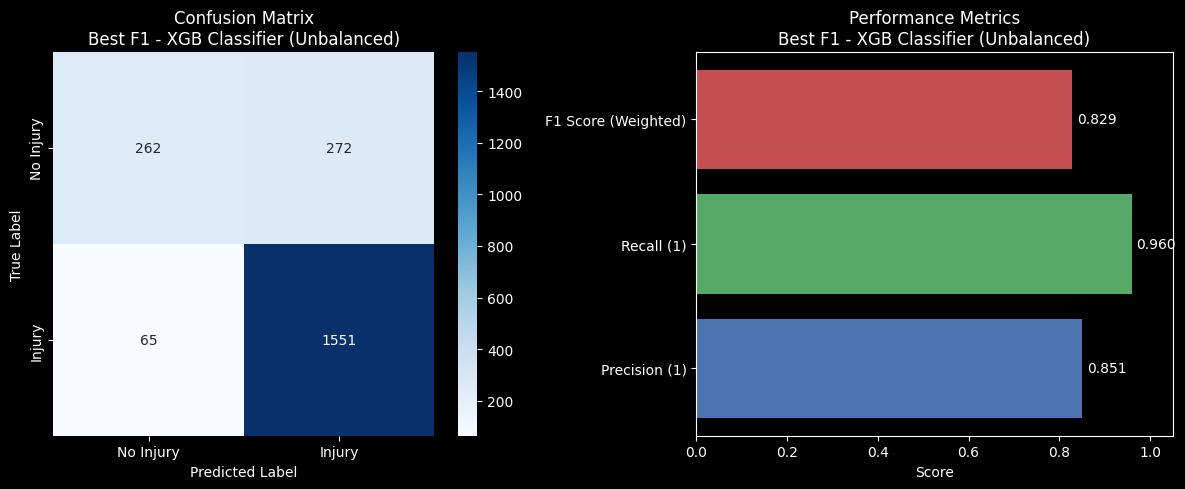


Runner-up - Random Forest (Unbalanced)


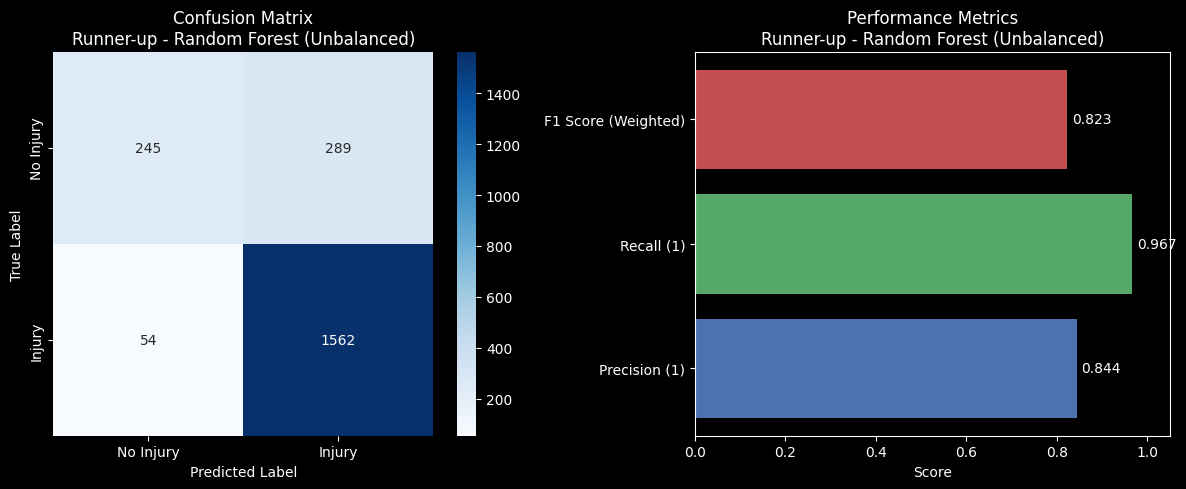

In [86]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

top_models = {
    "Best F1 - XGB Classifier (Unbalanced)": xgbClassifier_normal,
    "Runner-up - Random Forest (Unbalanced)": rf_normal
}

for name, model in top_models.items():
    y_pred = model.predict(X_test_scaled)

    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred,average = 'weighted')
    cm = confusion_matrix(Y_test, y_pred)

    print(f"\n{name}")


    fig, axes = plt.subplots(1, 2, figsize=(12, 5))


    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    axes[0].set_title(f"Confusion Matrix\n{name}")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")


    metrics = [precision, recall, f1]
    labels = ['Precision (1)', 'Recall (1)', 'F1 Score (Weighted)']
    axes[1].barh(labels, metrics, color=['#4c72b0', '#55a868', '#c44e52'])
    for i, v in enumerate(metrics):
        axes[1].text(v + 0.01, i, f"{v:.3f}", va='center')
    axes[1].set_xlim(0, 1.05)
    axes[1].set_title(f"Performance Metrics\n{name}")
    axes[1].set_xlabel("Score")

    plt.tight_layout()
    plt.show()



#APA Citations

Cheung, J., Cheou, N., Kassem, A., Rivas II, A., & Jin, J. (n.d.). NBA-Player-Injuries-Analysis. GitHub. https://github.com/Jecoc907/NBA-Player-Injuries-Analysis